# Solar Forcing Comparison

## Imports
Use basic elements of the scientific python stack

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from scipy import integrate

## Setup a few functions

### Calculating an energy spectrum for a specific l-shell and AP calculation

A routine (vdk2016) to return an energy spectrum for a specific l-shell and Ap
Calcs based on: 

***van de Kamp, M., Seppälä, A., Clilverd, M. A., Rodger, C. J., Verronen, P. T., and Whittaker, I. C. (2016), A model providing long‐term datasets of energetic electron precipitation during geomagnetic storms, J. Geophys. Res. Atmos., 121, 12,520– 12,540, [doi:10.1002/2015JD024212](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2015JD024212).***


In [2]:
def vdk2016(e, l, Ap):

    lpp = -0.7430*np.log(Ap) + 6.5257
    Spp = l - lpp

    # vdK2016 eqn.(8)

    A = 8.2091*Ap**0.16255
    b = 1.3754*Ap**0.33042
    c = 0.13334*Ap**0.42616
    s = 2.2833*Ap**-0.22990
    d = 2.7563e-4*Ap**2.6116

    # integral flux >30 keV (F30) electrons / (cm2 sr s)
    F30 = np.exp(A) / (np.exp(-b*(Spp-s)) + np.exp(c*(Spp-s)) + d)

    # vdK2016 eqn.(9)

    E = 3.3777*Ap**-1.7038 + 0.15
    bk = 3.7632*Ap**-0.16034
    sk = 12.184*Ap**-0.30111

    k = -1.0 / (E*np.exp(-bk*Spp) + 0.30450*np.cosh(0.20098*(Spp-sk))) - 1
    
    # solve eqn 3 for C
    # C is an offset, and k is the spectral gradient
    x=k+1
    c = F30*x/(1e3**x-30.**x)
    
    # calcualte the spectral density of the flux S(E) = CE^k
    # in electrons / (cm2 sr s keV)
    flux_spectral_density = e**k*c
    
    return flux_spectral_density

### Generate an energy grid

Generate a grid of energies for the flux spectrum. The energy range of the spectrum was set at 30–1000 keV, with nbins of logarithmically spaced grid points.

In [3]:
# Generate a grid of energies for the flux spectrum
# The energy range of the spectrum was set at 30–1000 keV, 
# with nbins of logarithmically spaced grid points.

def gen_energy_grid(nbins):

    e1 = np.log10(30.)
    e2 = np.log10(1000.)
    e = 10**(e1 + (e2-e1)*np.arange(nbins)/(nbins-1))
    
    return e

### Calculate how energy from top of atmosphere is deposited in rest of atmosphere

The function takes the energy spectrum at the top of the atmosphere and 
calculates how that energy is deposited in the atmosphere using the parameterization
described in [Fang et al., (2010)](https://opensky.ucar.edu/islandora/object/articles:10653)

***Fang, X., C. E. Randall, D. Lummerzheim, W. Wang, G. Lu, S. C. Solomon, 
and R. A. Frahm (2010), Parameterization of monoenergetic electron impact
ionization, Geophys. Res. Lett., 37, L22106, [doi:10.1029/2010GL045406.](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2010GL045406)***

Application of the new parameterization requires the following steps:

1. Calculate the Ci coefficients using equation (5) and Table 1.
2. Calculate the y values throughout the atmosphere using equation (1).
3. Calculate the normalized energy dissipation f values using equation (4).
4. Obtain the altitude profile of qtot by substituting the f values into equation (3).


In [4]:
def fang(y, Emono):
# Input: 
# y - normalized atmospheric column mass as a function of vertical location (z)
# Emono - is incident electron energy (keV)
# Output:
# f - quanity calculated by eqn. (4)

    # Table 1.
    p1 = np.array([(1.24616E+0,  1.45903E+0, -2.42269E-1,  5.95459E-2), 
                   (2.23976E+0, -4.22918E-7,  1.36458E-2,  2.53332E-3),
                   (1.41754E+0,  1.44597E-1,  1.70433E-2,  6.39717E-4),
                   (2.48775E-1, -1.50890E-1,  6.30894E-9,  1.23707E-3),
                   (-4.65119E-1, -1.05081E-1, -8.95701E-2,  1.22450E-2),
                   (3.86019E-1,  1.75430E-3, -7.42960E-4,  4.60881E-4),
                   (-6.45454E-1,  8.49555E-4, -4.28581E-2, -2.99302E-3),
                   (9.48930E-1,  1.97385E-1, -2.50660E-3, -2.06938E-3)])

    # terms in eq. (5)
    lne = np.log(Emono)
    lne2 = lne*lne
    lne3 = lne*lne2

    # step 2. calculate the C array in (5)
    c = np.zeros(8, dtype=float)
    for i in range(8):
        c[i] = np.exp(p1[i,0] + p1[i,1]*lne + p1[i,2]*lne2 + p1[i,3]*lne3)
        
    # eq. (4) - Normalized energy deposition
    f = c[0]*y**c[1]*np.exp(-c[2]*y**c[3]) + c[4]*y**c[5]*np.exp(-c[6]*y**c[7])
    
    return f

### Read in standard atmosphere data
Read in the Atmospheric density (rho) and temperature
return rho and the scale height (H) as a function of altitude

In [5]:
def read_atm():
    
    # assign constants
    kboltz = 1.380649e-23 # (J/K)
    amu = 1.6605e-27 # (kg)    
    grav = 9.8 # m/s2

    # read msis atmosphere
    x = pd.read_table('../data/msis2.0_atm_out.txt', header=0, sep='\s+')

    t = x['T']
    rho = x['rho']
    alt = x['alt']
    
    # calculate H, the scale height (cm)
    H = kboltz*t/(28.6*amu*grav)*1e2 

    return H, rho, alt

In [6]:
def iprmono(e, flux, rho, H):
    # assign constants
    epsilon = 0.035 # keV 

    ipr = np.zeros((e.size,rho.size))

    for i,energy in enumerate(e): # loop over energy index

        # step 1. (eq. 1) 
        y = (2/energy)*(rho*H/6.0e-6)**0.7
        f = np.zeros(y.size)

        for j,yy in enumerate(y):
            f[j] = fang(yy, energy)

        # calculate ipr (qtot) using eq. (3) for a specified flux at ea. energy
        Qmono = flux[i]*energy # (keV cm−2 s−1)
        ipr[i,:] = f*Qmono/(epsilon*H)

    return ipr

## Applying these functions
Create an energy grid for the energy flux between 30 and 1000 keV

In [7]:
nbins = 128 # sets resolution of the grid
e = gen_energy_grid(nbins)

Read in the Atmospheric density and scale height as a function of altitude

In [8]:
H, rho, alt = read_atm()

In [9]:
# The geomagnetic conditions (Ap) and location (l-shell) for 
# the IPR calculation
Ap = 54.625
l = 5.163

# calculate the top of the atmosphere energetic electron energy spectrum
flux_sd = vdk2016(e, l, Ap)

# van de Kamp is per steradian (electrons / (cm2 sr s keV))
# assume flux is isotropic inside a nominal bounce loss cone (BLC) angle
# of 66.3˚. The area of the BLC in sr is 2pi(66.3/90)
flux = 2.*np.pi*(66.3/90.) * flux_sd

# calculate the IPR as a function f height and energy
ipr = iprmono(e, flux, rho, H)

# integrate across the energy range to get total IPR
iprtot = integrate.simps(ipr, e, axis=0)

## Plot the results

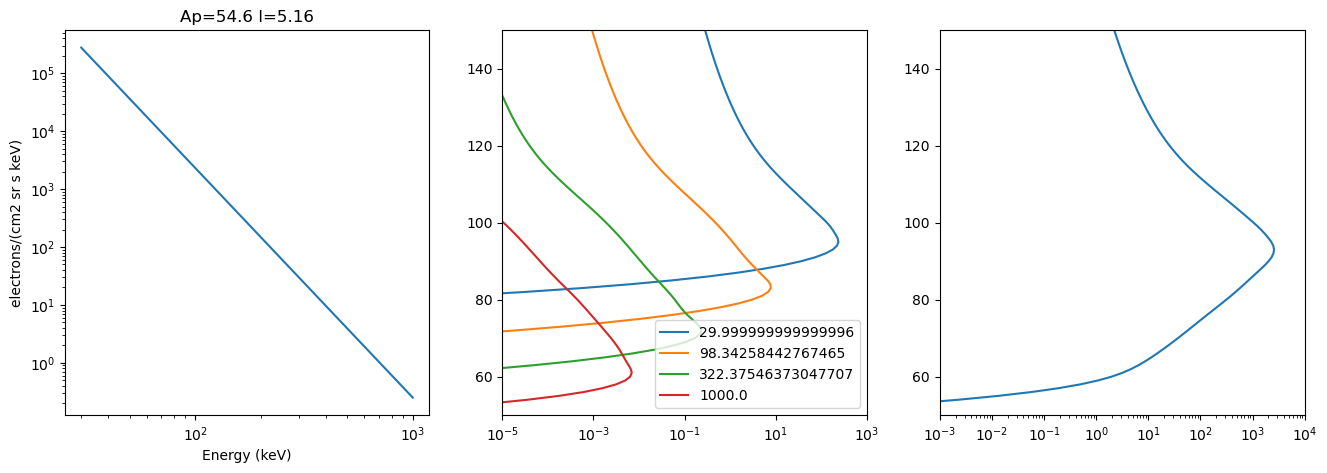

In [10]:
# plot the input energy spectrum, IPR(E) and total IPR

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

# plot the returned spectrum
plt.subplot(1, 3, 1)

plt.loglog(e,flux, "-")

ax = plt.gca()
ax.set_xlabel("Energy (keV)")
ax.set_ylabel("electrons/(cm2 sr s keV)")
ax.set_title("Ap=54.6 l=5.16")

# plot selected IPRs at various energies
plt.subplot(1, 3, 2)

plt.semilogx(ipr[0,:],  alt,  label=e[0])
plt.semilogx(ipr[43,:], alt,  label=e[43])
plt.semilogx(ipr[86,:], alt,  label=e[86])
plt.semilogx(ipr[127,:], alt,  label=e[127])

ax = plt.gca()
ax.set_ylim(50,150)
ax.set_xlim(1e-5,1e3)

ax.legend()

# plot selected IPRs at various energies
plt.subplot(1, 3, 3)

plt.semilogx(iprtot,alt)

ax = plt.gca()
ax.set_ylim(50,150)
ax.set_xlim(1e-3,1e4)

plt.show()


## Compare with CMIP6 Forcing File

Open the [HEPPA SOLARIS](https://solarisheppa.geomar.de/) forcing file using xarray

In [11]:
ds = xr.open_dataset('/glade/work/marsh/ref_data/solar/solarforcing-REFD1-day_input4MIPs_solar_CCMI-2022_SOLARIS-HEPPA-3-2_gn_19500101-20191231.nc')

In a centered dipole magnetic field model, the path along a given L shell can be described as r=L$\cos ^{2}\lambda$ 
where r is the radial distance (in planetary radii) to a point on the line $\lambda$ is its geomagnetic latitude, and L is the L-shell of interest.

In [12]:
glat = ds['glat']
lshell = 1.01 / np.cos(glat*np.pi/180.)**2

### Take a look at a solar storm from April 2020
Notice the maximum IPR at maximum in Ap - they are aligned!

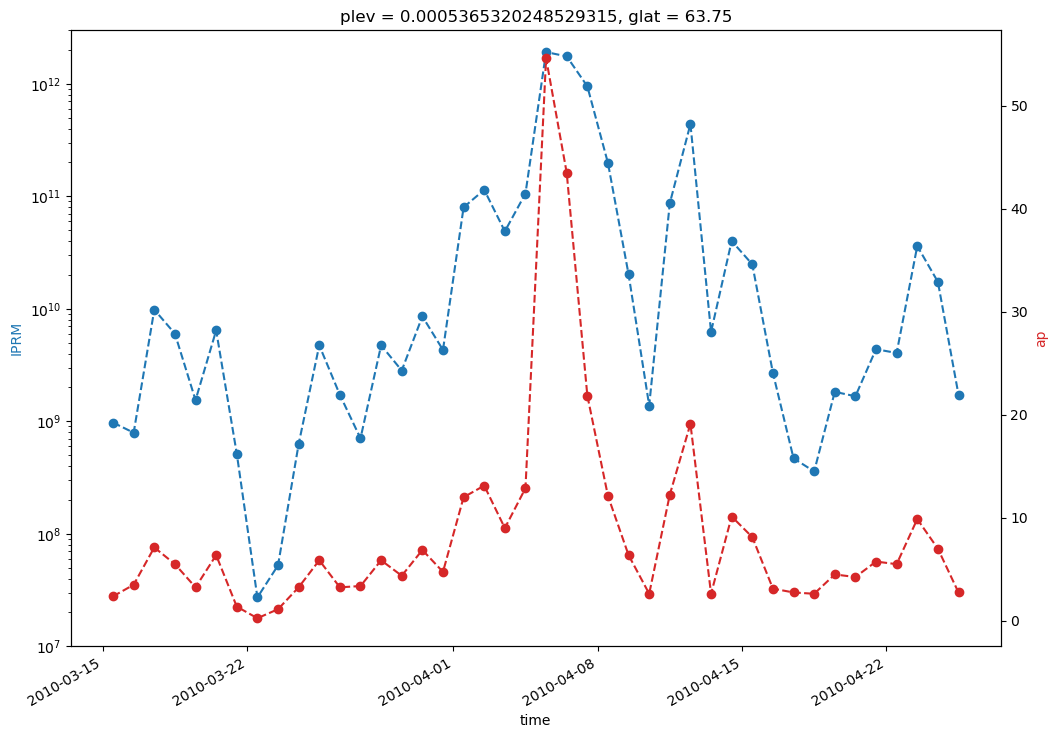

In [13]:
plt.figure(figsize=(12,8))

ax = plt.gca()
color = 'tab:blue'

ds['iprm'].sel(time=slice("2010-03-15T12:00:00", "2010-04-25T12:00:00"),glat=63.750,)\
    .isel(plev=9).plot(marker='o', linestyle='dashed', color=color)

ax.set_ylim([1e7,3e12])
ax.set_yscale('log')
ax.set_ylabel('IPRM', color=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'

ds['ap'].sel(time=slice("2010-03-15T12:00:00", "2010-04-25T12:00:00")) \
        .plot(marker='o', linestyle='dashed', color=color)

ax2.set_ylabel('ap', color=color) 
plt.show()

### Take a look at the ap value from that peak time

In [14]:
# select maximum in geomagnetic storm in April 2010
storm_date = "2010-04-05T12:00:00"

ap = ds['ap'].sel(time = storm_date)
iprm = ds['iprm'].sel(time = storm_date)

print('ap:', ap.values)

ap: 54.625


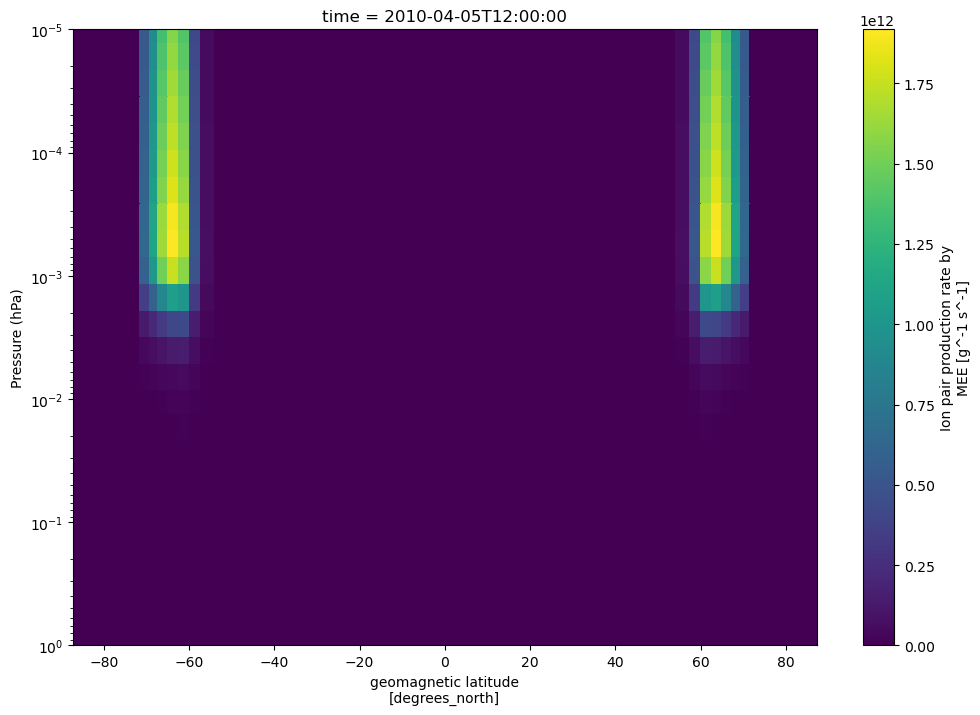

In [15]:
plt.figure(figsize=(12,8))

iprm.plot()

#control the look of the output
ax = plt.gca()

ax.set_ylim([1,1e-5])
ax.set_yscale('log')
ax.set_ylabel('Pressure (hPa)')

plt.show()

 0   -82.500    59.282 0.00000e+00 
 1   -72.938    11.732 0.00000e+00 
 2   -70.188     8.792 6.42260e+11 
 3   -68.500     7.519 1.12311e+12 
 4   -66.250     6.227 1.64548e+12 
 5   -63.750     5.163 1.91807e+12 
 6   -61.250     4.366 1.71395e+12 
 7   -58.750     3.753 5.20478e+11 
 8   -55.938     3.220 6.77236e+10 
 9   -52.188     2.687 2.02846e+09 
10   -47.500     2.213 1.38501e+08 
11   -42.500     1.858 0.00000e+00 
12   -37.500     1.605 0.00000e+00 
13   -32.500     1.420 0.00000e+00 
14   -25.000     1.230 0.00000e+00 
15   -10.000     1.041 0.00000e+00 
16    10.000     1.041 0.00000e+00 
17    25.000     1.230 0.00000e+00 
18    32.500     1.420 0.00000e+00 
19    37.500     1.605 0.00000e+00 
20    42.500     1.858 0.00000e+00 
21    47.500     2.213 1.38501e+08 
22    52.188     2.687 2.02846e+09 
23    55.938     3.220 6.77235e+10 
24    58.750     3.753 5.20476e+11 
25    61.250     4.366 1.71394e+12 
26    63.750     5.163 1.91806e+12 
27    66.250     6.227 1.645

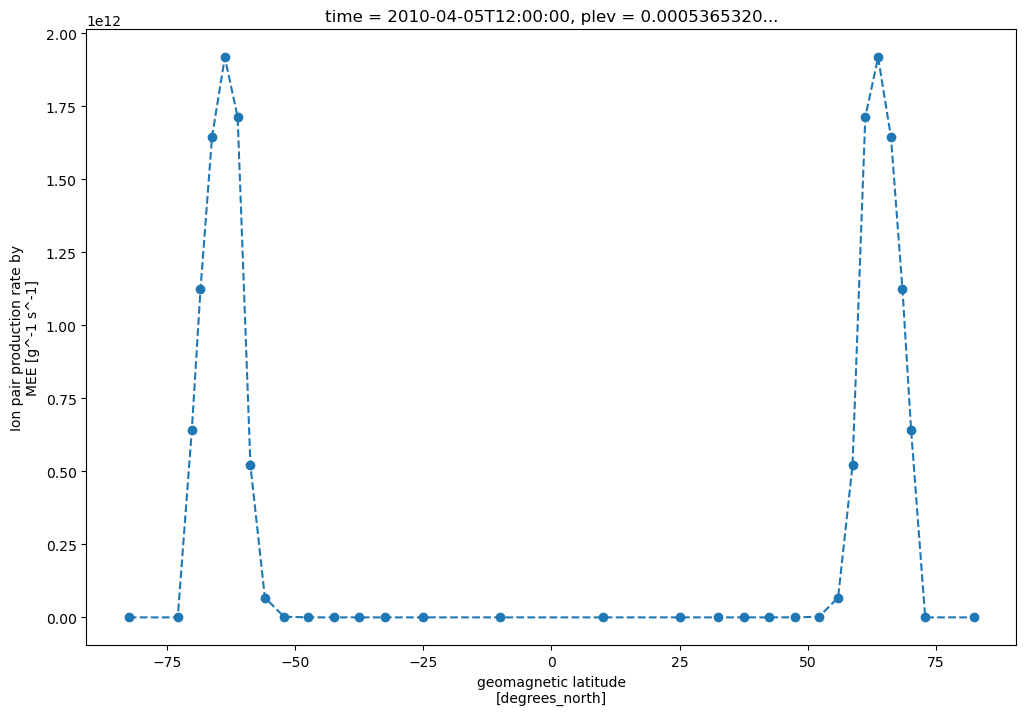

In [16]:
for iy, y in enumerate(glat.values):
    print("%2i %9.3f %9.3f %.5e " % (iy, y, lshell[iy].values, iprm[9,iy].values))
    
plt.figure(figsize=(12,8))

iprm[9,:].plot(marker='o', linestyle='dashed')

plt.show()

# IPRM only calculated for l-shells between 10 and 2

## Take a look at a vertical profile of iprm and iprtot

l-shell: 5.163090118854937
ap: 54.625


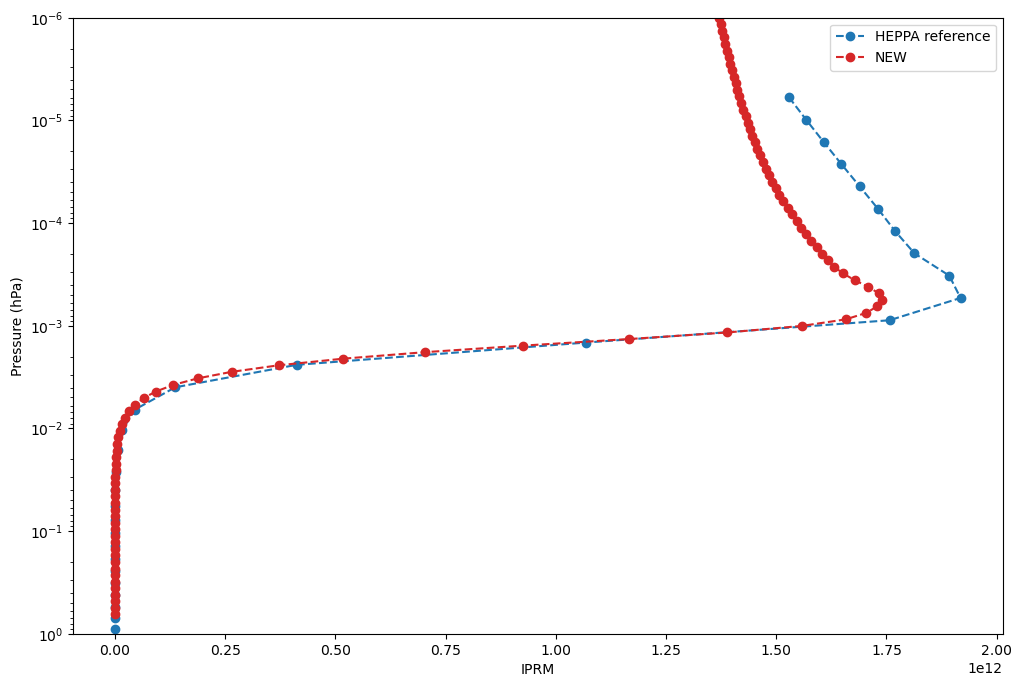

In [17]:
# compare iprm to iprtot from calculation above (note scaling!)

plt.figure(figsize=(12,8))

ax = plt.gca()
color = 'tab:blue'

ref = iprm.sel(glat=63.750)
print('l-shell:', lshell.sel(glat=63.750).values)
print('ap:', ap.values)

plt.plot(ref, ds['plev'], marker='o', linestyle='dashed', color=color, label='HEPPA reference')

ax.set_xlabel('IPRM')

ax.set_ylim([1,1e-6])
ax.set_yscale('log')
ax.set_ylabel('Pressure (hPa)')

color = 'tab:red'
plt.plot(iprtot/rho,1013.*np.exp(-alt/6.8), marker='o', linestyle='dashed', color=color, label='NEW')

plt.legend()

plt.show()
